## Dataset Preparation Tutorial
This is a simple demo to create a dataset for L+S-Net. We assume you have extracted the multi-coil kspace data. Based on that we will:
1. generate the sensitivity maps (csm) using [The Berkeley Advanced Reconstruction Toolbox (BART) toolbox](https://mrirecon.github.io/bart/)
2. generate the coil-combined images as references (labels)
3. prepare a corresponding random undersampling Cartesian mask.

First, let's import some useful libraries:

In [1]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os


We will using a multi-coil k-space data for demonstration. The data is generated from [Harvard radial cardiac dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CI3WB6). It has been reggridded to cartesian grid for demostraction. You can download the regridded kspace data from [here](https://1drv.ms/u/s!AkfR9I9GCfI3htgF1OdhTIA59U-hig?e=bkZGJw) and put it in `./create_dummy_data`.

In [2]:
if not os.path.exists('kspace.h5'):
    print("Please download the demo data and put it in 'create_dummy_data'")
else:
    with h5py.File('kspace.h5') as f:
        kspace = np.array(f.get('kspace'), dtype=np.complex64)
    nSlices, nPhases, nCoils, nPE, nRO = kspace.shape
    print("'nSlices, nPhases, nCoils, nPE, nRO' of kspace is", kspace.shape)

'nSlices, nPhases, nCoils, nPE, nRO' of kspace is (1, 18, 16, 192, 192)


Then we use BART to estimate the sensitivity maps. Please refer to the [official installation guide](http://mrirecon.github.io/bart/) to build and install BART and make sure that you sucessfully [install the python wrapper](https://github.com/mrirecon/bart/blob/master/README).

In this demo, only the 24*24 kspace center is used to estimate the sensitivity maps. If you are interested, you can refer to another [ESPIRiT demo](https://mrirecon.github.io/bart/examples.html#21) for more information.

In [3]:
from bart import bart

#calculate the average of all the phases for estimating sensitivity maps
kspace_bart = np.ascontiguousarray(np.transpose(np.mean(kspace, 1), (0, 2, 3, 1)))  #nSlice, nPE, nRO, nCoils
smaps = np.zeros((nSlices, nCoils, nPE, nRO), dtype=np.complex64)

# use BART to estimate sensitivity maps. -m for generating only one map, -r24 for only using the 24*24 kspace center for estimation.
for slidx in range(nSlices):
    smaps_bart = bart(1, 'ecalib -m1 -r24', kspace_bart[slidx:slidx+1:,...])[0]
    smaps[slidx] = np.ascontiguousarray(np.transpose(smaps_bart, (2, 0, 1))).astype(np.complex64)

Done.


Let's visualize the sensitivity maps!

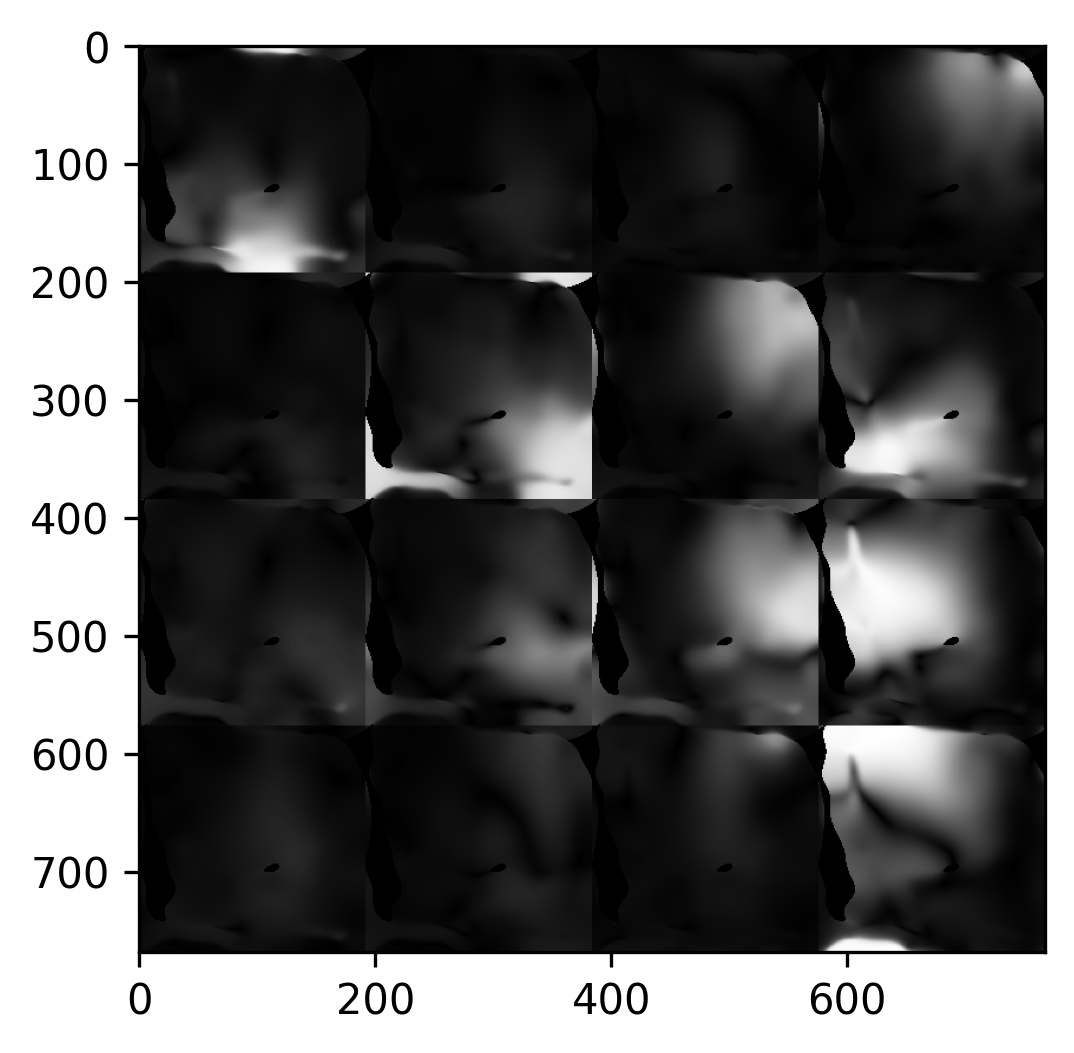

In [4]:
def plot_array(img, axes=(-2, -1), M=None, N=None):
    assert img.ndim == 3

    ksz_N = img.shape[-1]
    ksz_M = img.shape[-2]

    if M is None or N is None:
        M = int(np.floor(np.sqrt(img.shape[0])))
        N = int(np.ceil(img.shape[0] / M))
    else:
        assert M * N == img.shape[0]
    
    arr = np.zeros((M*ksz_M, N*ksz_N), dtype=img.dtype)
    for i in range(img.shape[0]):
        ii = np.mod(i, M)
        jj = i // M
        arr[ii*ksz_M:ii*ksz_M + ksz_M, jj*ksz_N:jj*ksz_N+ksz_N] = img[i]

    return arr

def normalize(img, vmin=None, vmax=None, max_int=255.0):
    """ normalize (magnitude) image
    :param image: input image (np.array)
    :param vmin: minimum input intensity value
    :param vmax: maximum input intensity value
    :param max_int: maximum output intensity value
    :return: normalized image
    """
    if np.iscomplexobj(img):
        # print('img is complex! Take absolute value.')
        img = np.abs(img.copy())
    if vmin == None:
        vmin = np.min(img)
    if vmax == None:
        vmax = np.max(img)
    img = (img - vmin)*(max_int)/(vmax - vmin)
    img = np.minimum(max_int, np.maximum(0.0, img))
    return img

smaps_arr = np.abs(plot_array(smaps[0]))
f = plt.figure(dpi=300)
plt.imshow(normalize(smaps_arr), cmap='gray')

It looks good! Let's combine the coil images and get the reference!

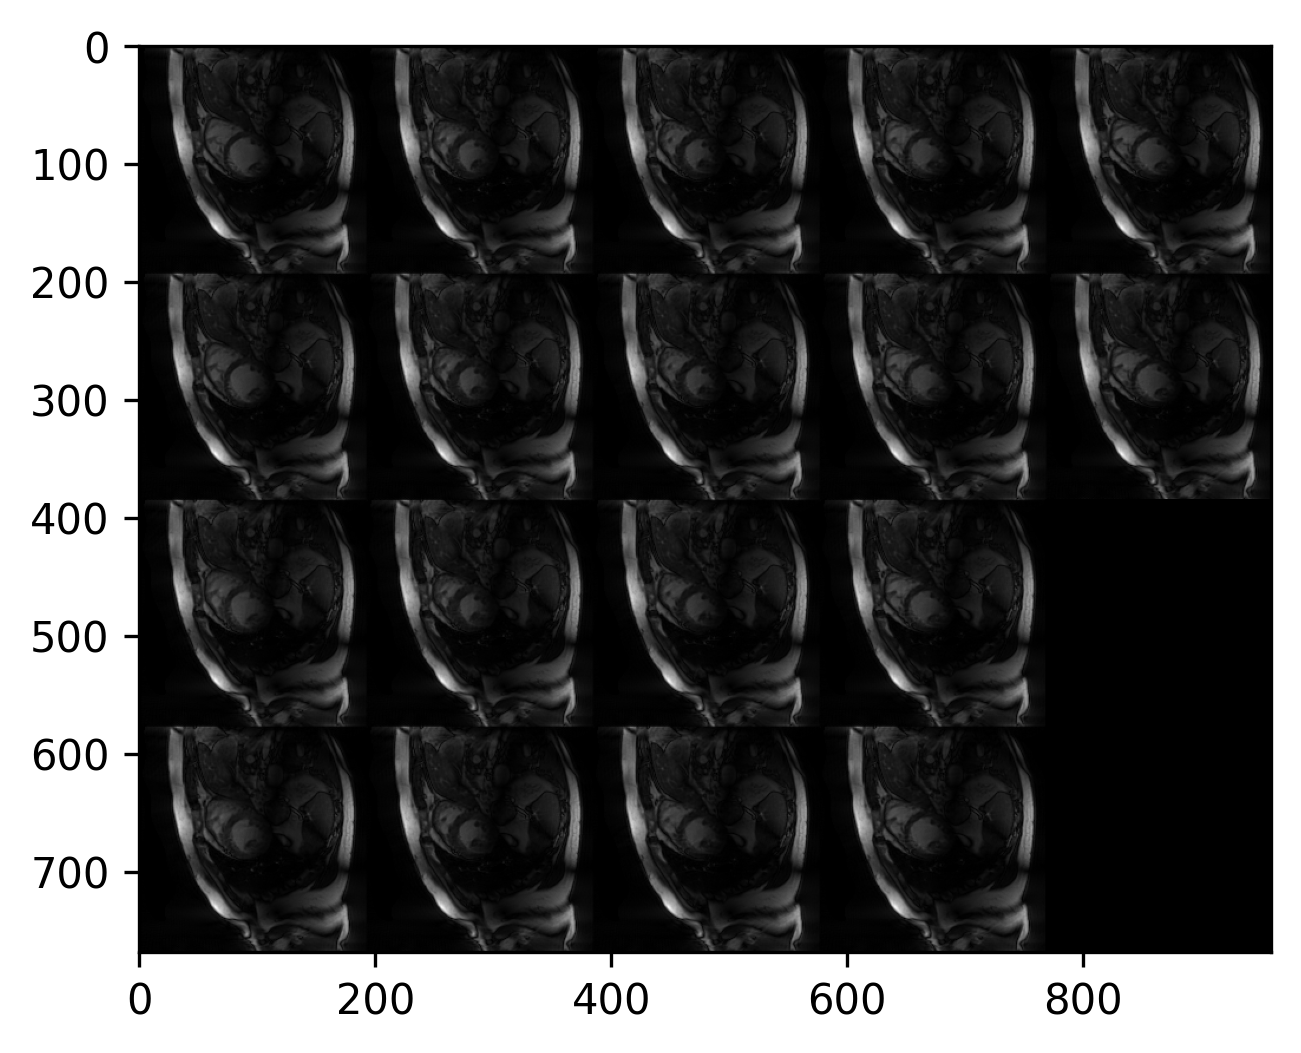

In [5]:
import sys
sys.path.insert(0,'../')
from tools.mymath import ifft2c

image_coil = ifft2c(kspace)
reference = np.sum(image_coil*smaps, 2)

coil_image = np.abs(plot_array(reference[0,:,:,:]))
f = plt.figure(dpi=300)
plt.imshow(normalize(coil_image), cmap='gray')

Okey. Almost done! Some reshape before save them into `.h5` file.

In [6]:
# reshape data
kspace = np.transpose(np.squeeze(kspace, 0), [1,0,2,3])
smaps = np.transpose(smaps, [1,0,2,3])
reference = np.squeeze(reference, 0)
print(kspace.shape, smaps.shape, reference.shape)

hf = h5py.File('dummy_dataset.h5', mode='w')
hf.create_dataset('kspace', data=kspace)
hf.create_dataset('csm', data=smaps)
hf.create_dataset('label', data=reference)
hf.close()

(16, 18, 192, 192) (16, 1, 192, 192) (18, 192, 192)


Mask is also needed. Here we generate a random cartesian mask for our demo.

(18, 192, 192)


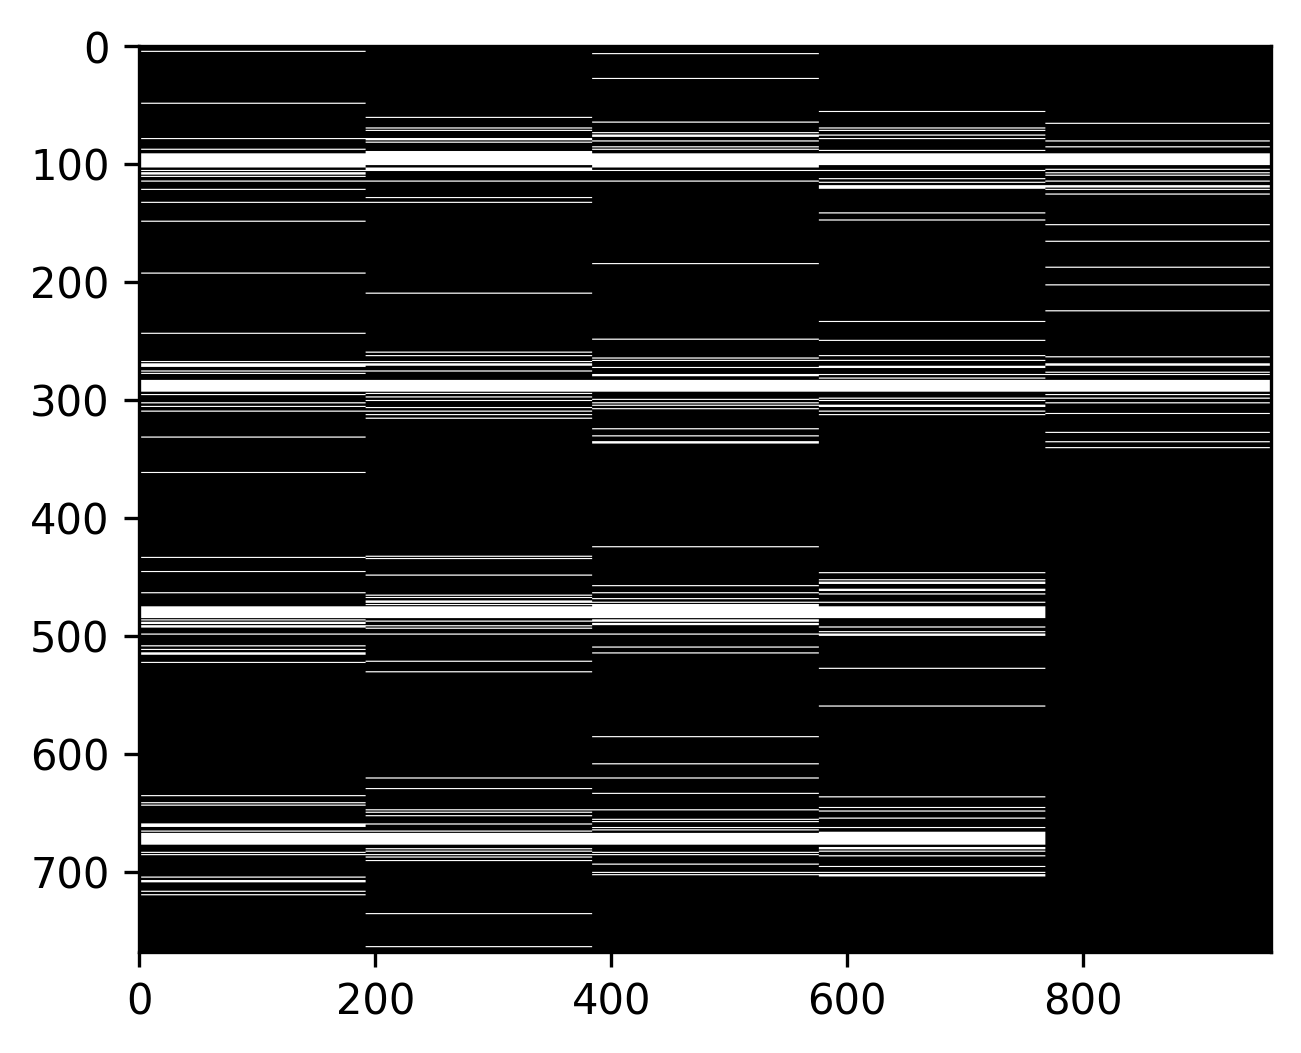

In [7]:
from tools.tools import cartesian_mask
mask = cartesian_mask(shape=[nPhases,nPE, nRO], acc=8, sample_n=10, centred=True)
scio.savemat('../mask/dummy_mask_8.mat', {'mask': mask})
print(mask.shape)

mask_arr = np.abs(plot_array(mask))
f = plt.figure(dpi=300)
plt.imshow(normalize(mask_arr), cmap='gray')

Data preparation is done! The dummy dataset is stored in `create_dummy_data/dummy_dataset.h5`. Please try `python main.py --data='DUMMY'` to play with the demo!
 
Don't forget to use `tensorboard --logdir='./logs'` to activate tensorboard for better visualization. `ffmpeg` library is needed if you want to visualize the dynamic data in `gif`. You can simply install it by `sudo apt install ffmpeg` if you are using Ubuntu.